<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/CreatingVGG_Inception_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Resource: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/
 
# Example of creating a CNN model with a VGG block
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

<h1>VGG</h1>

In [2]:
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(filters = n_filters, kernel_size=3, padding='same', activation='relu')(layer_in)
  
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

In [3]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)

# therefore, structute: Input -> Conv2d -> Conv2d, MaxPool2d
# if you want, we can add more vggblocks like
# second_block = vgg_block(layer, 128, 2)

In [4]:
# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


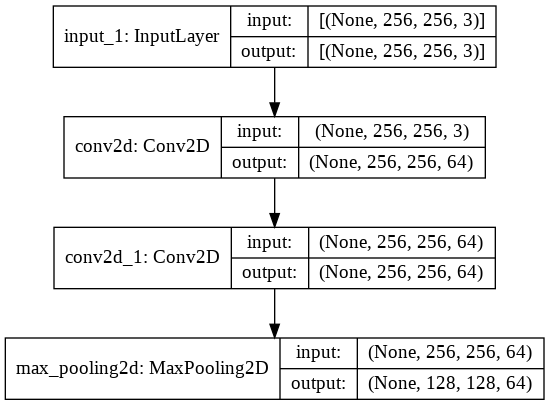

In [5]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='vgg_block.png')

In [6]:
# Now adding multiple vgg blocks
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)

# add vgg module
layer = vgg_block(layer, 128, 2)

# add vgg module
layer = vgg_block(layer, 256, 4)

# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0   

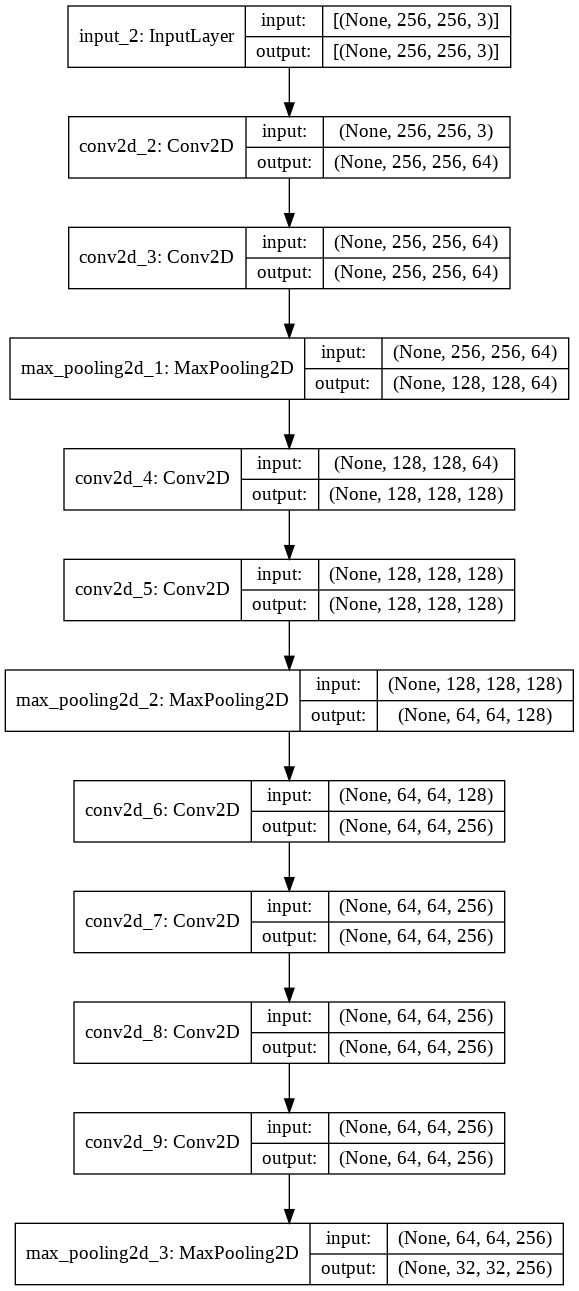

In [7]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

<h1>GoogleNet</h1>

In [8]:
from keras.layers.merge import concatenate

In [9]:
def naive_inception(layer_in, f1, f2, f3):
    # 1x1 convolution
    conv1 = Conv2D( filters=f1, kernel_size=1, padding='same' )(layer_in)

    # conv 3x3
    conv2 = Conv2D( filters=f2, kernel_size=3, padding='same' )(layer_in)

    # conv 5x5
    conv3 = Conv2D( filters=5, kernel_size=5, padding='same' )(layer_in)

    # max pooling
    max_pool = MaxPooling2D( pool_size=(3, 3), strides=(1, 1), padding='same' )(layer_in)

    # # concatenate filters, assumes filters( channels ) last
    layer_out = concatenate( [conv1, conv2, conv3, max_pool], axis=-1 )

    return layer_out

In [10]:
# define model input
visible = Input(shape=(256, 256, 3))

# add inception module
layer = naive_inception(visible, 64, 128, 32)

In [11]:
# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 64) 256         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 128 3584        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 5)  380         input_3[0][0]                    
____________________________________________________________________________________________

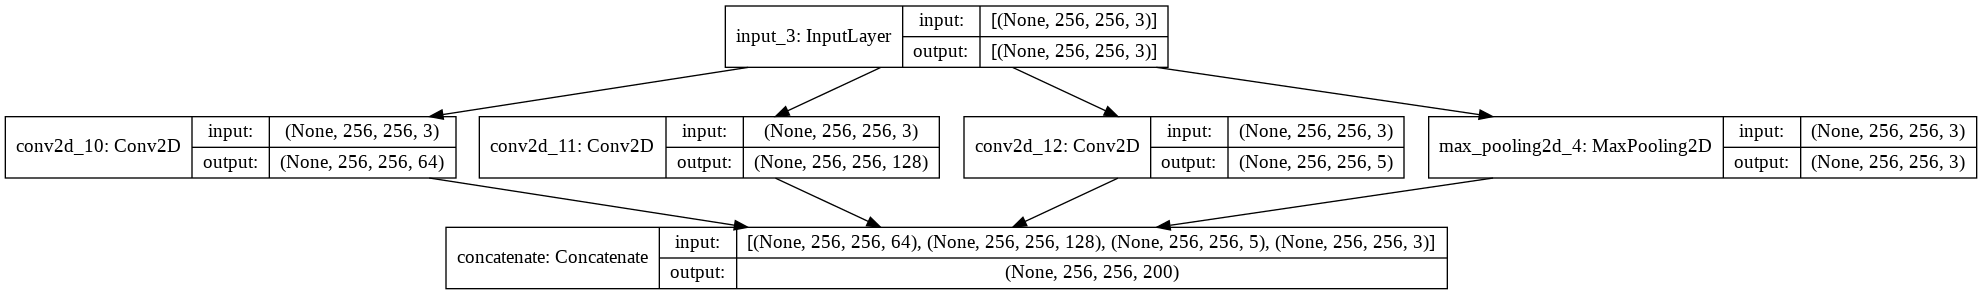

In [12]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [13]:
# The function below implements this optimization improvement with parameterization so that you can control
#  the amount of reduction in the number of filters prior to the 3×3 and 5×5 convolutional layers and the number of increased 
#  filters after max pooling.

# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)

    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [14]:
# define model input
visible = Input(shape=(256, 256, 3))

# add inception block 1
layer = inception_module(visible, f1=64, f2_in=96, f2_out=128, f3_in=16, f3_out=32, f4_out=32)

In [15]:
# add inception block 2
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

In [16]:
# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 96) 384         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 16) 64          input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 3)  0           input_4[0][0]                    
____________________________________________________________________________________________

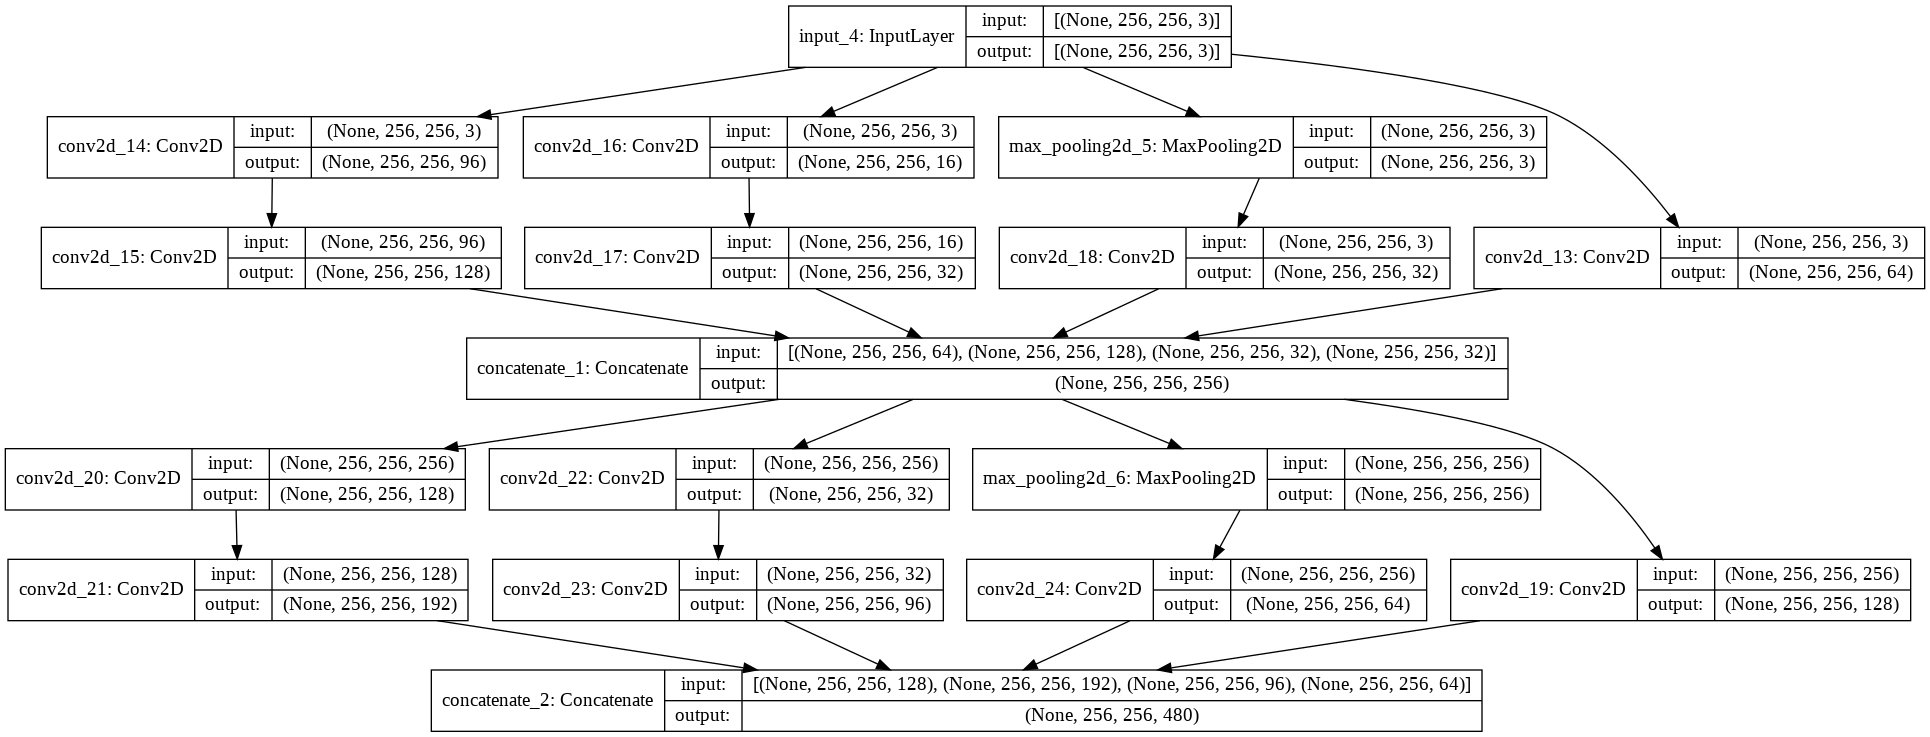

In [17]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

<h1>ResNet</h1>

In [18]:
from keras.layers import add

In [21]:
def residual_module(layer_in, n_filters):
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
 
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
 
	# add filters, assumes filters/channels last
	layer_out = add([conv2, layer_in])
	
    # activation function
	layer_out = tf.nn.relu(layer_out)
	return layer_out

In [20]:
# A limitation with this direct implementation is that if the number of filters in the input layer does not 
# match the number of filters in the last convolutional layer of the module (defined by n_filters), then we 
# will get an error.

# One solution is to use a 1×1 convolution layer, often referred to as a projection layer, to either increase the number of filters
#  for the input layer or reduce the number of filters for the last convolutional layer in the module. 
# The former solution makes more sense, and is the approach proposed in the paper, referred to as a projection shortcut.

In [28]:
import tensorflow as tf

# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in

	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal', name='IncreasingFilters')(layer_in)
  
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', name='Conv1')(layer_in)
 
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal', name='Conv2')(conv1)
 
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
 
	# activation function
	layer_out = tf.nn.relu(layer_out)
 
	return layer_out

In [29]:
# define model input
visible = Input(shape=(256, 256, 3))

# add vgg module
layer = residual_module(visible, 64)

# The input shape is (256, 256, 3), therefore number_of_channels_input != n_filters, it will perform 1x1 conv.
# The spape of the kernel will be 1x1x3, therefore each kernel will result in 256x256 output, and we have 64 such 
# kernels, resulting in 256x256x64

In [30]:
# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 256, 256, 64) 36928       Conv1[0][0]                      
__________________________________________________________________________________________________
IncreasingFilters (Conv2D)      (None, 256, 256, 64) 256         input_7[0][0]                    
____________________________________________________________________________________________

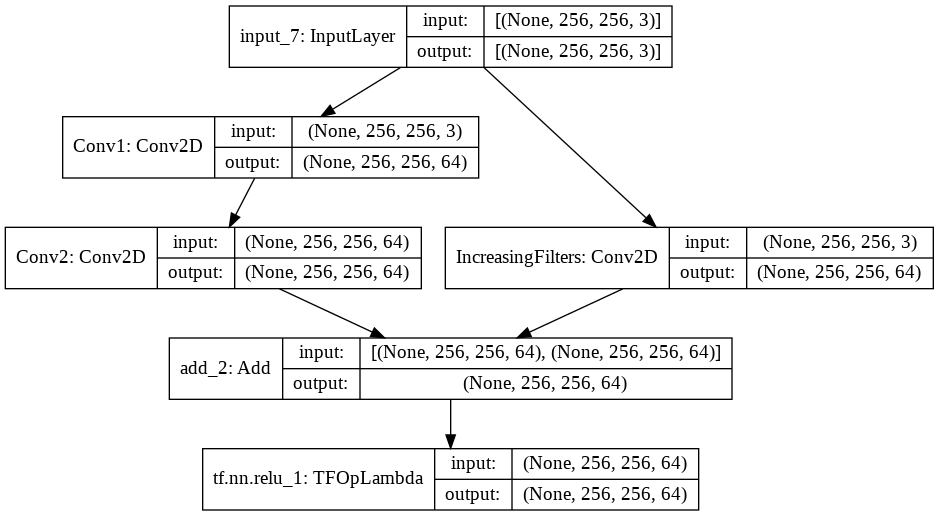

In [31]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')